In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

D:\sentiment-analysis\sentiment.py:182: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label + r'(,|$)', regex=True))
D:\sentiment-analysis\sentiment.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


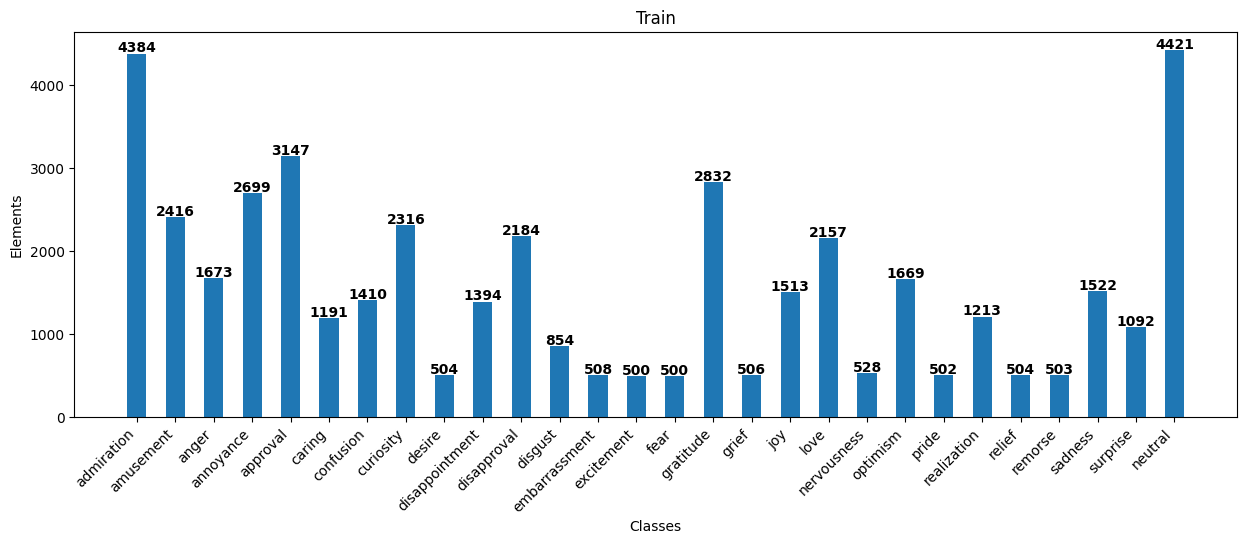

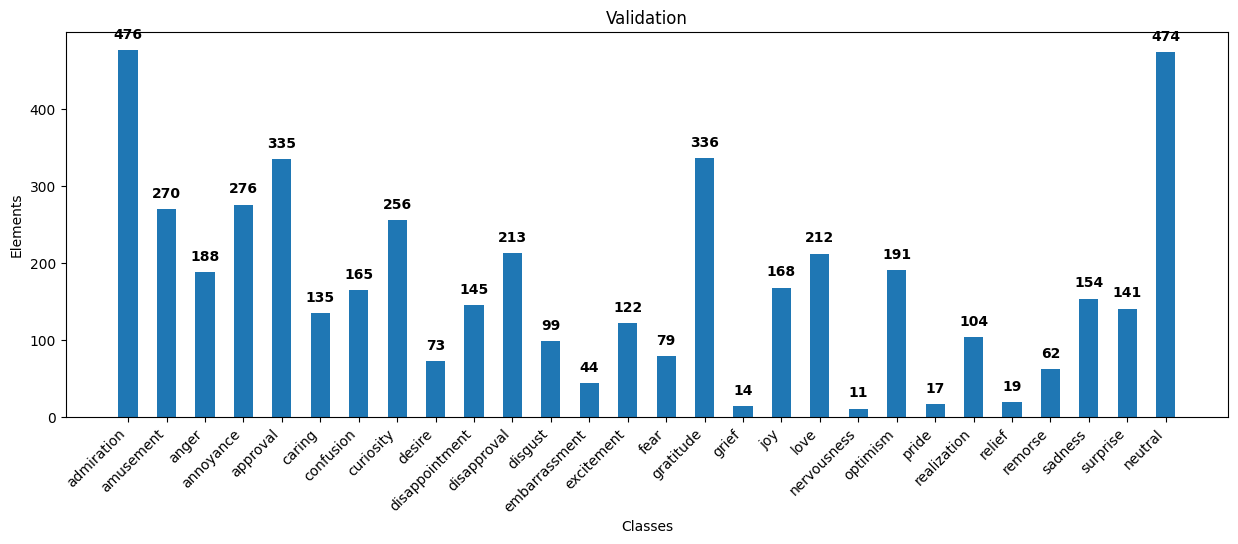

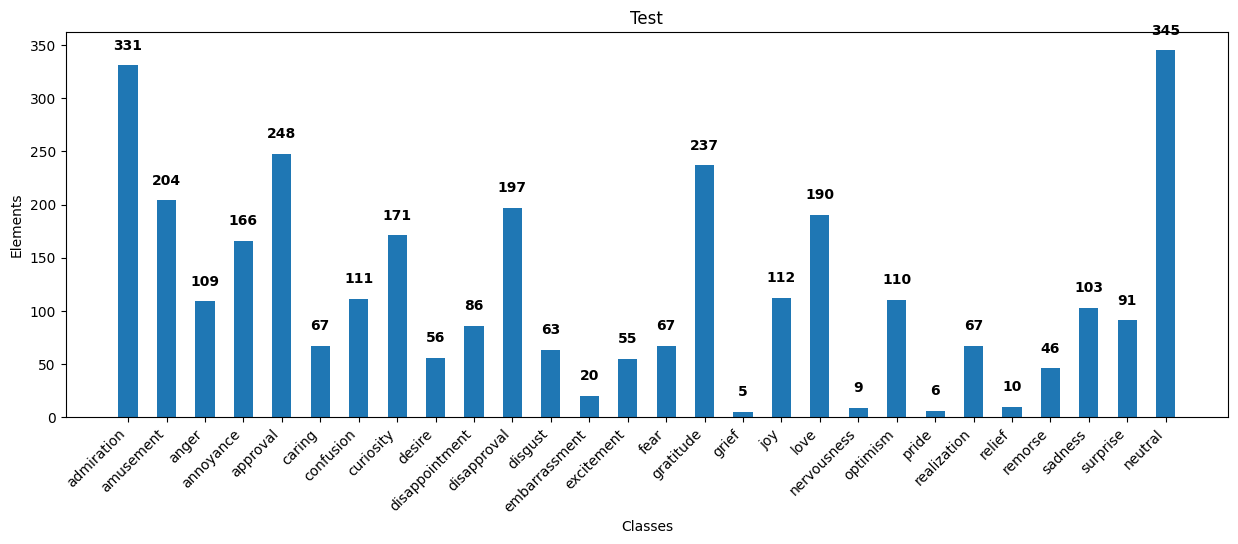

CPU times: total: 8.48 s
Wall time: 8.75 s


In [3]:
%%time
BATCH_SIZE = 32


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.9,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [6]:
text_test = ['I am feeling sad and lonely today']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 3110 6517 1998 9479 2651  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.99999136  0.08191041 -0.9997363   0.9891061  -0.9994392   0.6426271
 -0.99642986 -0.04943833  0.08171504  0.04948686 -0.7958412  -0.04962895]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.1542702  -0.44949532 -3.3050992  ... -0.27842605 -0.4901824
   0.78527725]
 [-0.8928114  -0.68425363 -0.13896418 ... -1.6181747  -1.3698293
   0.50157887]
 [-0.9860739  -0.31338978 -1.2287494  ... -0.502259   -1.7966256
   0.5462902 ]
 ...
 [-1.6846545  -0.00387354 -0.12156503 ... -1.3318069  -0.74090356
   1.5787063 ]
 [-1.350074   -0.18482555 -0.18486801 ... -1.5990545  -0.8795686
   1.7834572 ]
 [-0.7529241  -0.72506434 -0.4427926  ... -1.5915537  -0.76583195
   1.740164  ]]


In [9]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(len(classes), activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [10]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.65556103 0.69114655 0.5703886  0.54477316 0.675611   0.6537581
  0.5989618  0.6643622  0.59290713 0.5906584  0.68121743 0.66380346
  0.66323704 0.542168   0.59295136 0.5815071  0.5656115  0.58878076
  0.6136619  0.6697723  0.6376025  0.6144924  0.5815229  0.640172
  0.59894353 0.633097   0.6722422  0.6471351 ]], shape=(1, 28), dtype=float32)


In [11]:
classifier = build_classifier_model()

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5

from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
hist = classifier.fit(x=train_ds, validation_data=val_ds, epochs=epochs,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/20
1111/1111 [==============================] - 709s 629ms/step - loss: 0.2034 - precision@0.5/admiration: 0.4844 - recall@0.5/admiration: 0.2336 - precision@0.5/amusement: 0.2726 - recall@0.5/amusement: 0.2661 - precision@0.5/anger: 0.0818 - recall@0.5/anger: 0.0986 - precision@0.5/annoyance: 0.1071 - recall@0.5/annoyance: 0.0519 - precision@0.5/approval: 0.1676 - recall@0.5/approval: 0.0191 - precision@0.5/caring: 0.0337 - recall@0.5/caring: 0.0160 - precision@0.5/confusion: 0.0525 - recall@0.5/confusion: 0.0135 - precision@0.5/curiosity: 0.2734 - recall@0.5/curiosity: 0.1490 - precision@0.5/desire: 0.0197 - recall@0.5/desire: 0.0139 - precision@0.5/disappointment: 0.0371 - recall@0.5/disappointment: 0.0552 - precision@0.5/disapproval: 0.0662 - recall@0.5/disapproval: 0.0687 - precision@0.5/disgust: 0.0282 - recall@0.5/disgust: 0.0667 - precision@0.5/embarrassment: 0.0224 - recall@0.5/embarrassment: 0.0236 - precision@0.5/excitement: 0.0107 - recall@0.5/excitement: 0.0060 - p

In [14]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

103/103 [==============================] - 16s 150ms/step - loss: 0.0980 - precision@0.5/admiration: 0.6050 - recall@0.5/admiration: 0.7311 - precision@0.5/amusement: 0.7679 - recall@0.5/amusement: 0.8431 - precision@0.5/anger: 0.3974 - recall@0.5/anger: 0.5505 - precision@0.5/annoyance: 0.2556 - recall@0.5/annoyance: 0.1386 - precision@0.5/approval: 0.5093 - recall@0.5/approval: 0.2218 - precision@0.5/caring: 0.4737 - recall@0.5/caring: 0.2687 - precision@0.5/confusion: 0.4865 - recall@0.5/confusion: 0.1622 - precision@0.5/curiosity: 0.4872 - recall@0.5/curiosity: 0.6667 - precision@0.5/desire: 0.7333 - recall@0.5/desire: 0.3929 - precision@0.5/disappointment: 0.2000 - recall@0.5/disappointment: 0.2442 - precision@0.5/disapproval: 0.4366 - recall@0.5/disapproval: 0.3147 - precision@0.5/disgust: 0.5079 - recall@0.5/disgust: 0.5079 - precision@0.5/embarrassment: 0.5833 - recall@0.5/embarrassment: 0.3500 - precision@0.5/excitement: 0.5455 - recall@0.5/excitement: 0.1091 - precision@0.5/f

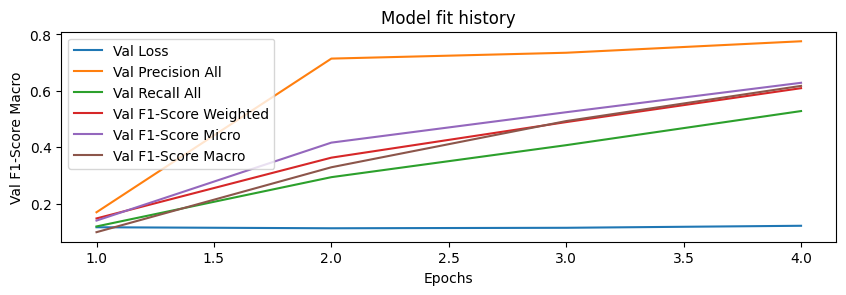

In [15]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
sentiment.plot_history(stats_graps)

In [16]:
sentiment.calc_TP_perc(test_ds, classifier)

0.46526508226691043

In [19]:
from sentiment import EMOJI_MAP
def test_examples(model, classes):
    examples = [
        'I am feeling great today!',
        'The weather is so good',
        'I have performed well at the university',
        'The war has started',
        'He is desperate in this cruel world',
        'I love the feeling when my girlfriend hugs me',
        'I hate monday mornings',
        'Look forward to seeing you today',
        'Merry Christmas! I told Santa you were good this year and '
        'asked him to bring you a year full of joy and pleasure ',
        'brilliant! Such a detailed review, it was a pleasure, thank you! '
        'Guys, make sure you find time to read :) Aaaaand you can actually choose sth new)',
        'I have the new pan for pancakes.',
        "I'm wearing a special red ribbon for luck.",
        'OMG, yep!!! That is the final answer! Thank you so much!',
        'I am so glad this is over',
        'Sorry, I feel bad for having said that',
        'Happy birthday, my friend! I wish you a lot of success!',
        'What a shame! I will never talk to him',
        "What if she knows? We don't know what to do",
        'WOW! I am really into cinema',
        "What if I don't pass the exam? I will never get this driving license!",
        'I have just come up with the idea of birthday present. Let me explain...',
        "Don't worry, all of us will pass this test. It is just to 'evaluate our knowledge.",
        ' miss my grandad. I am feeling so lonely after her death. '
        'I just lost my closest person..',
        'Skipping lessons is so miserable for Oxford stundets!',
        'Have a rest, my boy. You had a long trip. I will make us tea and bring a cake.',
        'What a man! My son got the highest rate and will study in Cambridge. '
        'Our family is so proud of him!',
        "Mmmm, delicious. That's totally the best pasta in Italy!",
    ]
    model_scores = model(tf.constant(examples))
    np_classes = np.array(classes)
    for idx, predictions in enumerate(model_scores):
        predicted = (predictions >= 0.5).numpy()
        if predicted.any():
            emotions = np_classes[predicted]
        else:
            print('WARNING! Model not sure (all predictions less than 0.5)')
            emotions = np_classes[[predictions.numpy().argmax()]]
        with_emojis = []
        for emotion in emotions:
            try:
                emoji = EMOJI_MAP[emotion]
            except KeyError:
                emoji = 'N/A'
            with_emojis.append(f'{emotion} {emoji}')
        print('{}: {}'.format(examples[idx], ' '.join(with_emojis)))
test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
WARNING! Model not sure (all predictions less than 0.5)
I have performed well at the university: approval 👍
WARNING! Model not sure (all predictions less than 0.5)
The war has started: admiration 👏
He is desperate in this cruel world: anger 😡
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: approval 👍
Look forward to seeing you today: approval 👍
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): admiration 👏 gratitude 🙏
I have the new pan for pancakes.: amusement 😂
I'm wearing a special red ribbon for luck.: optimism 🤞
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
WARNING! Model not sure (all predictions less than 0.5)
I am so glad this is ove

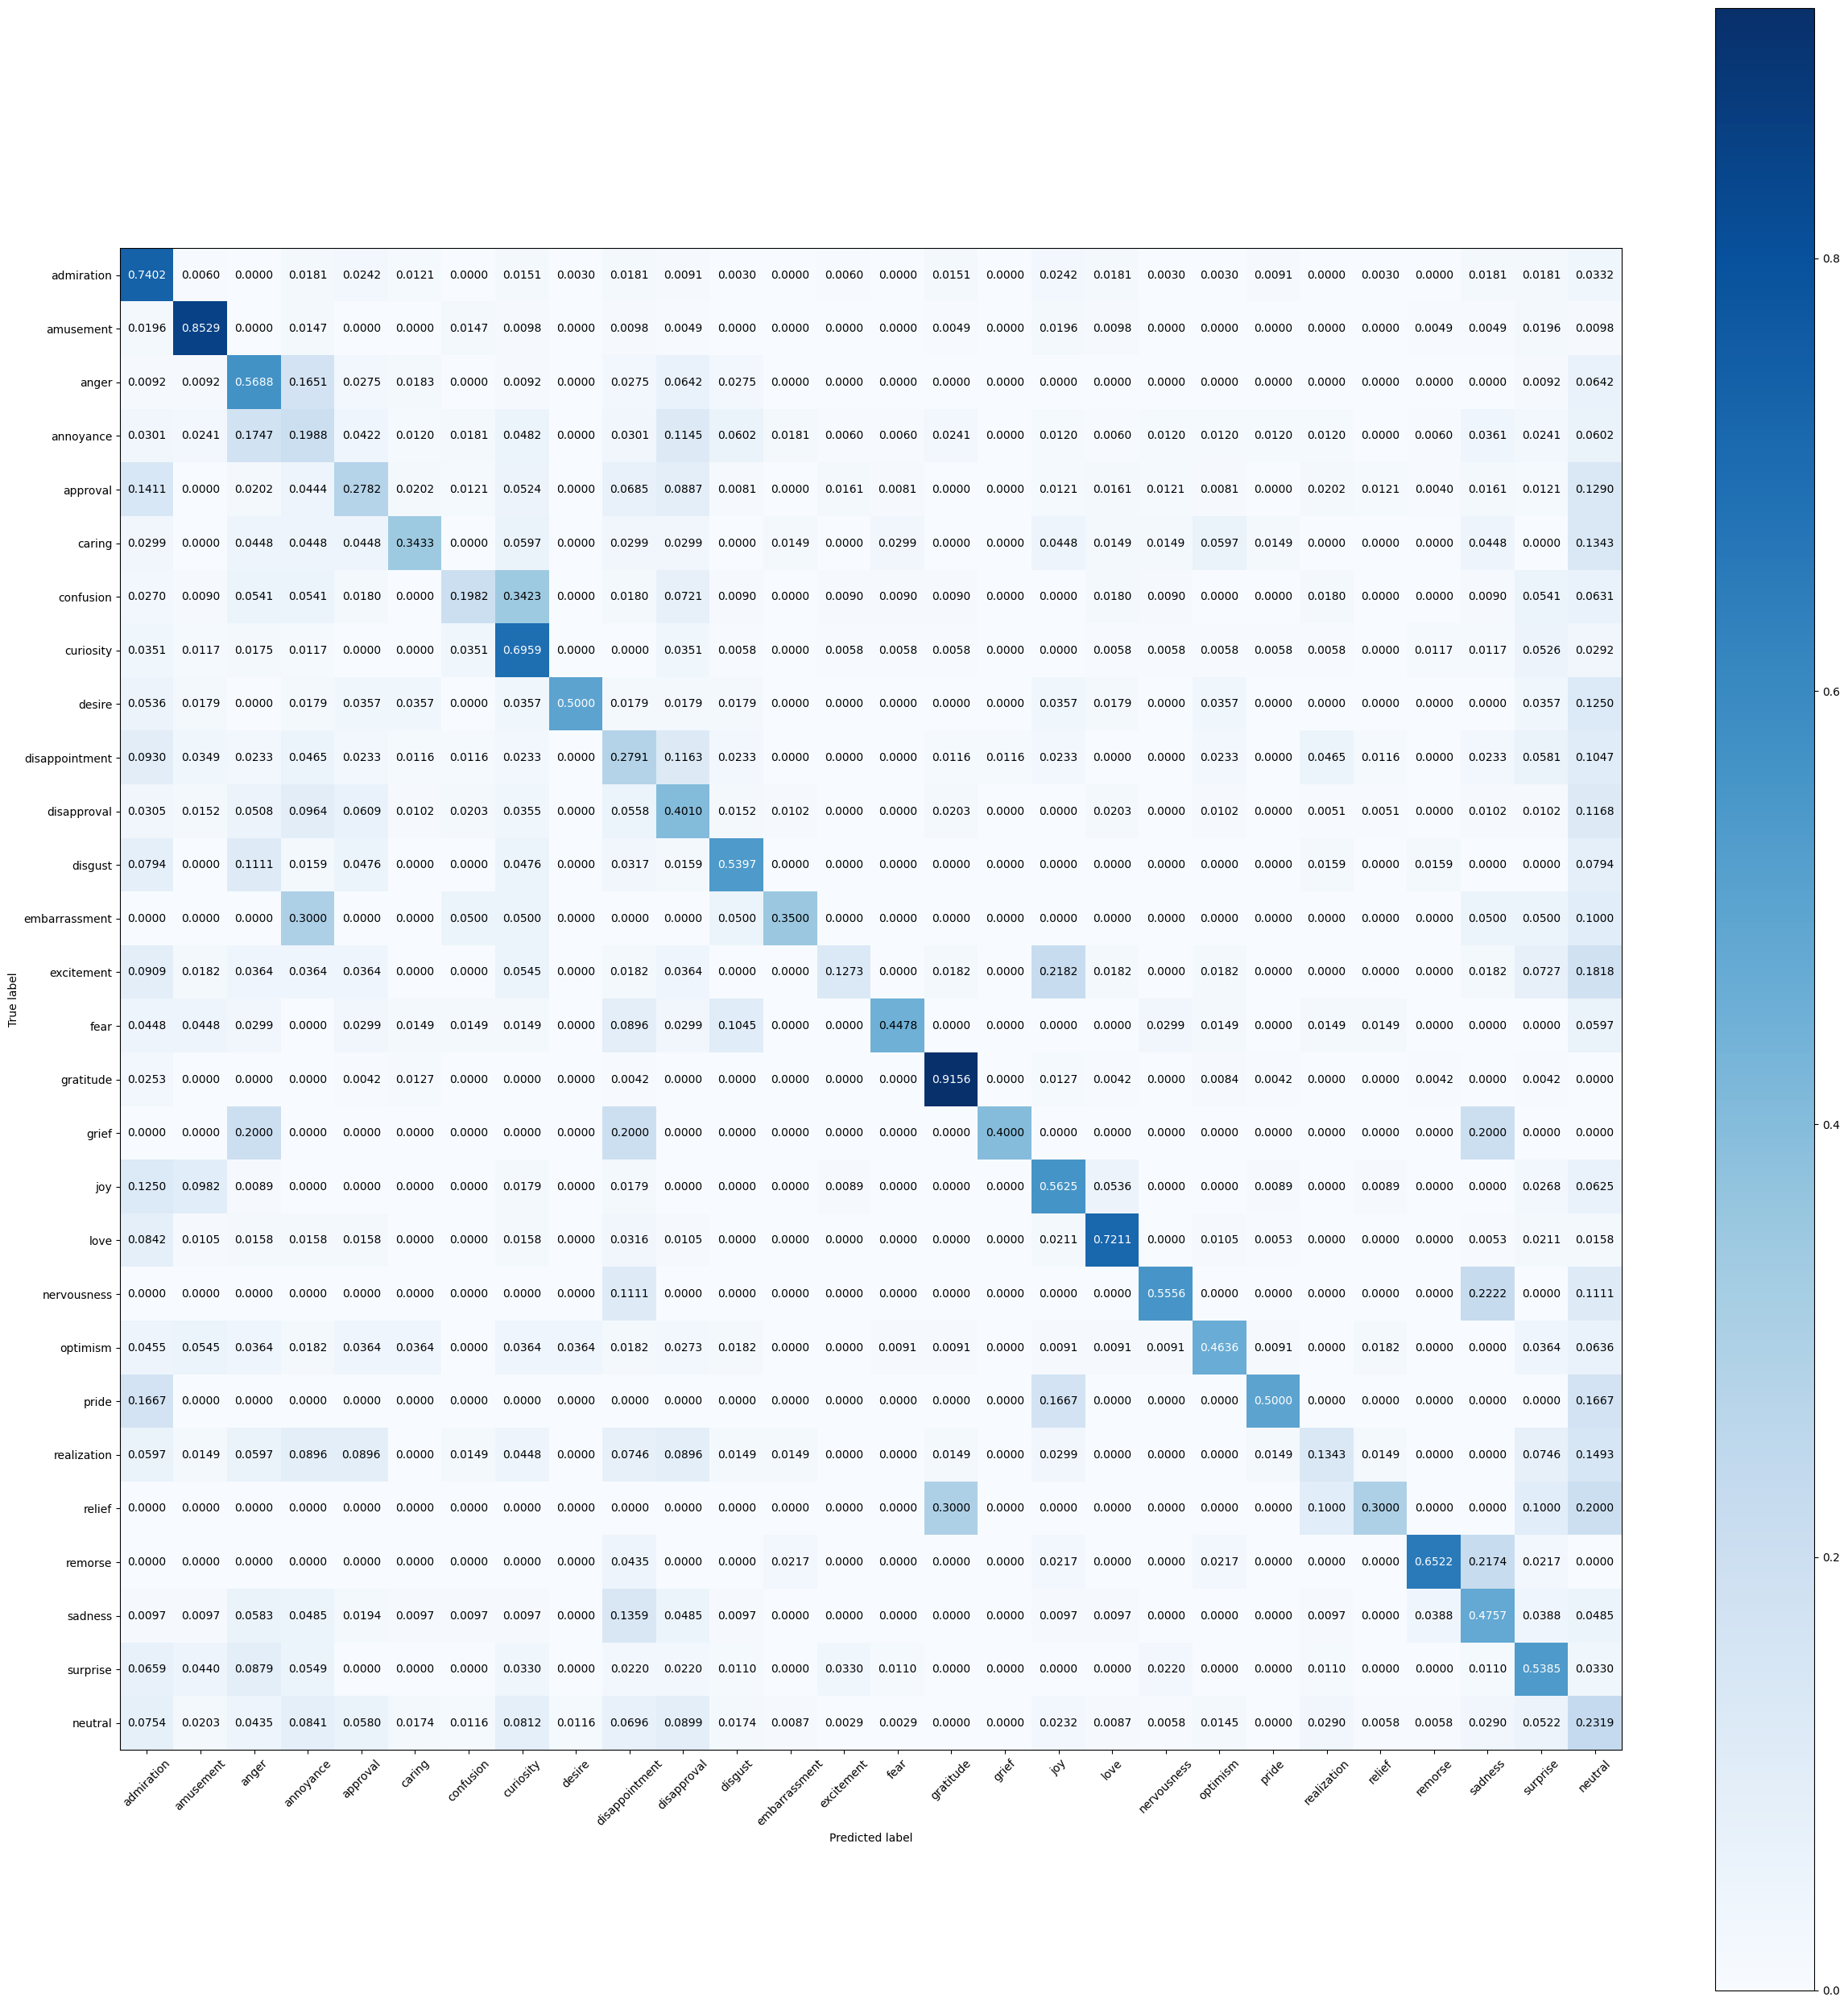

In [20]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

1/1 [==============================] - 1s 576ms/step


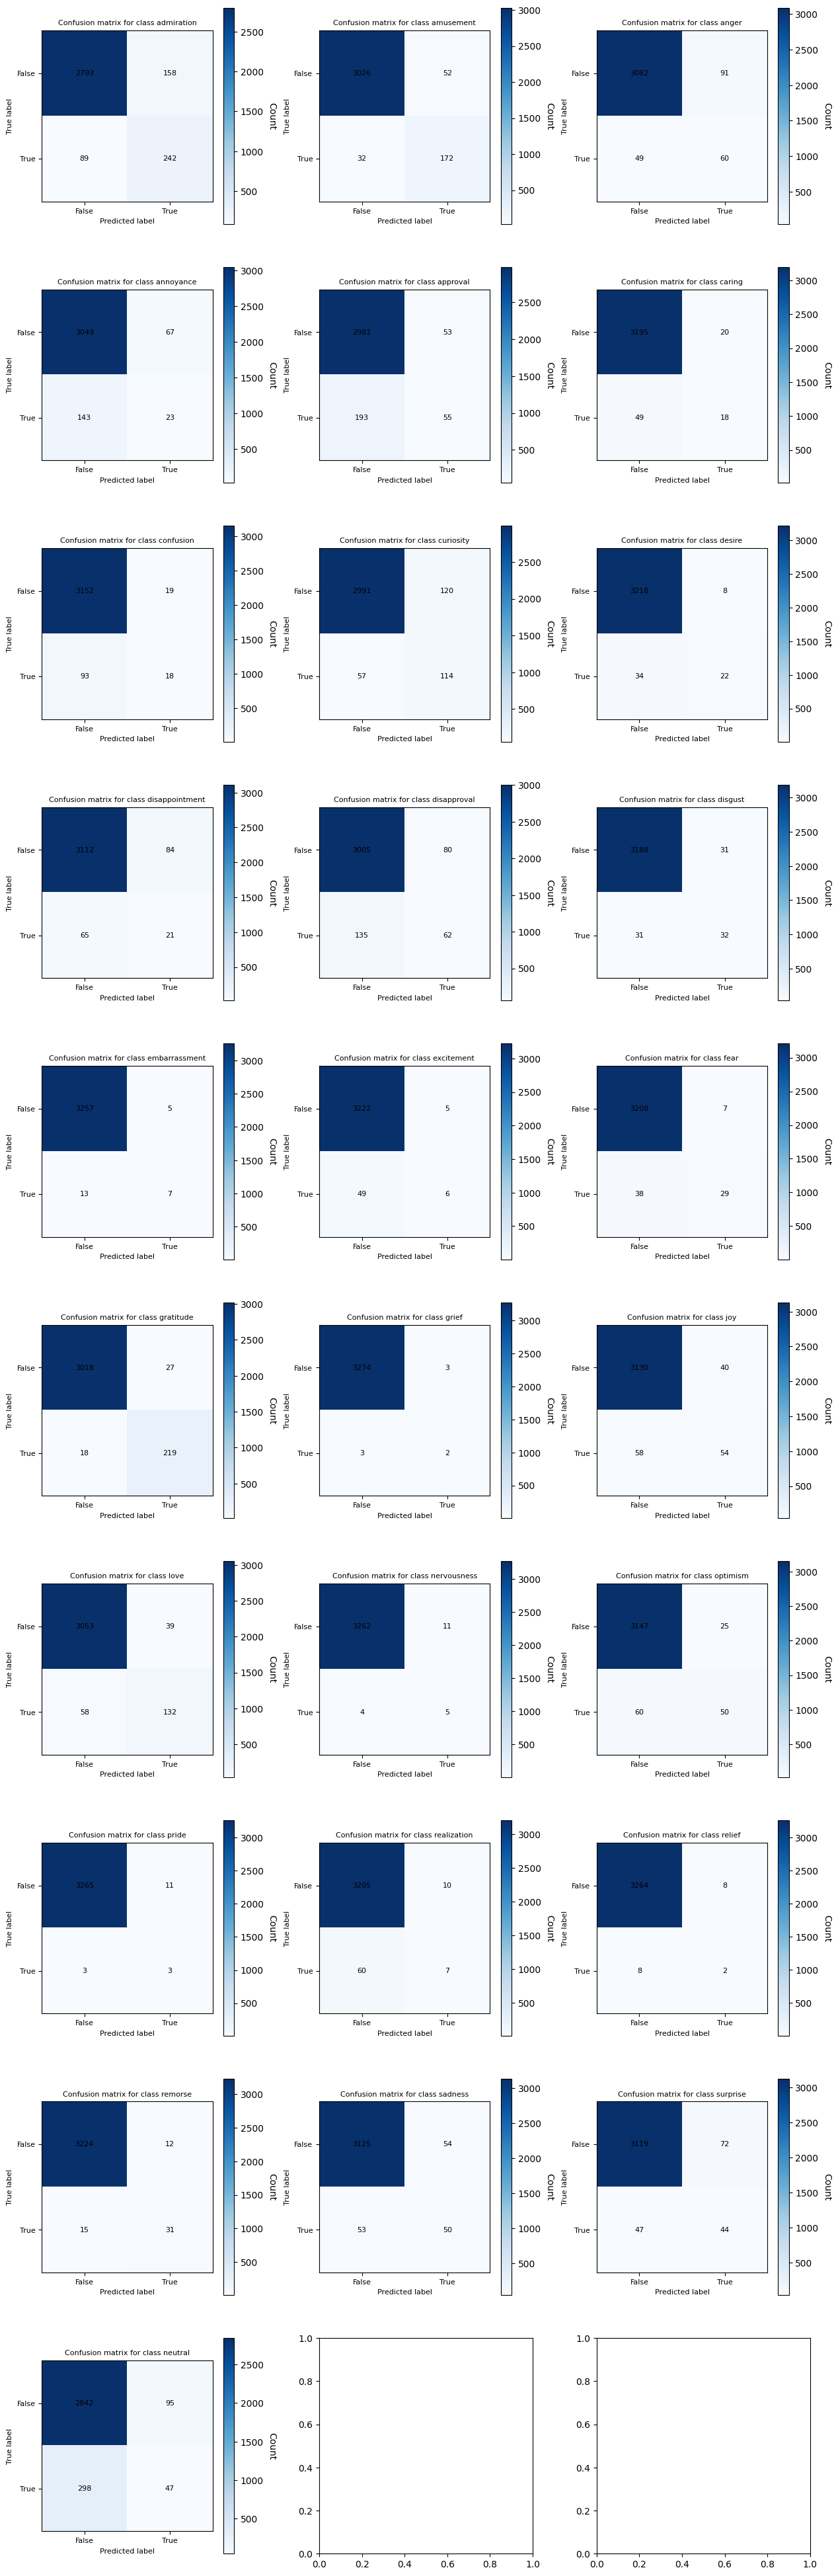

In [22]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes)

In [24]:
classifier.save('./models/bert_BEST', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/bert_BEST\assets


INFO:tensorflow:Assets written to: ./models/bert_BEST\assets


## Notes 
### Experiment 1
__Encoder:__ tiny BERT  
__Dataset:__ BATCH_SIZE=32, fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  
__Learning:__ Adam optimizer LR=1e-3, eary stop at 3, limit for 10 epochs, no class weights   
__Result:__
F1Score all: `0.50900`  
Accuracy: `0.53427`  
Some classes had zero-metrics  

### Experiment 2
__Encoder:__ tiny BERT  
__Dataset:__ BATCH_SIZE=32, fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  
__Learning:__ AdamW optimizer, dynamic LR, eary stop at 3, limit for 20 epochs, no class weights   
__Result:__
F1Score all: `0.48769`  
Accuracy: `0.50511605`  
Grief and relief have zero metrics

### Experiment 3
__Encoder:__ tiny BERT  
__Dataset:__ BATCH_SIZE=32, fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  Added dense layer having 128 units and relu activation and additional dropout  
__Learning:__ Adam optimizer, LR=1e-3, eary stop at 3, limit for 20 epochs, no class weights   
__Result:__
F1Score all: `0.47223`  
Accuracy: `0.5516558`  
Annoyance, confusion, grief and relief have zero metrics

### Experiment 4
__Encoder:__ tiny BERT  
__Dataset:__ BATCH_SIZE=32, fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  Added dense layer having 128 units and relu activation and additional dropout  
__Learning:__ Adam optimizer, LR=3e-4, eary stop at 3, limit for 20 epochs, no class weights   
__Result:__
F1Score all: `0.`  
Accuracy: `0.`  
??? zero metrics  
__Try this arch with class weights__

### Experiment 2 - WITH CLEANSING
__Encoder:__ tiny BERT  
__Dataset:__ BATCH_SIZE=32, fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__  
__Learning:__ Adam optimizer LR=1e-3, eary stop at 3, limit for 20 epochs, no class weights   
__Result:__
F1Score all: `0.48990`  
Accuracy: `0.55022556`  
Grief, nervousness, and relief have zero metrics


_Using class weights significatly decreased the performance (try again with another arch). Try oversampling low classes? Try learning rate 3e-4_